In [2]:
import torch
import numpy as np
from functools import partial

In [ ]:
import matplotlib.pyplot as plt

In [3]:
import sys
#sys.path.append('./NVIDIA_physicsnemo_examples-weather_corrdiff_DB/datasets')
sys.path.append('/leap/DB_scratch/physicsnemo/research/corrdiff_27_Nov')

In [4]:
from datasets.SSH_SST import SSH_SST_Dataset

In [5]:
dataset = SSH_SST_Dataset(
    data_path='',
    stats_path='',
    preload=False,
    sel_time=[0, 2000]  # Just 10 samples for demo
)

In [6]:
print(f"Dataset size: {len(dataset)}")
print(f"Image shape: {dataset.image_shape()}")
print(f"Input channels: {len(dataset.input_channels())}")
print(f"Output channels: {len(dataset.output_channels())}")


Dataset size: 2000
Image shape: (128, 128)
Input channels: 10
Output channels: 10


In [7]:
# ==============================================================================
# STEP 2: Get a single sample
# ==============================================================================
image_tar, image_lr = dataset[1000]
image_tar_t = torch.from_numpy(image_tar)
image_lr_t = torch.from_numpy(image_lr)
print(f"\nSample shapes:")
print(f"  Target (HR): {image_tar_t.shape}")
print(f"  Input (LR): {image_lr_t.shape}")


Sample shapes:
  Target (HR): torch.Size([10, 128, 128])
  Input (LR): torch.Size([10, 128, 128])


In [8]:
# ==============================================================================
# STEP 3: Load Models
# ==============================================================================
from physicsnemo import Module

# Load regression model (deterministic baseline)
#net_reg = Module.from_checkpoint("/leap/DB_scratch/physicsnemo/research/corrdiff_27_Nov/results_nyc_window_2/checkpoints/checkpoints_regression/UNet.0.10000384.mdlus")
#net_reg = net_reg.eval().cuda().to(memory_format=torch.channels_last)

# Load diffusion residual model (stochastic refinement)
net_res = Module.from_checkpoint('/leap/DB_scratch/physicsnemo/research/corrdiff_27_Nov/results_ssh_sst_noreg/checkpoints/checkpoints_diffusion/EDMPrecondSuperResolution.0.10000384.mdlus')
net_res = net_res.eval().cuda().to(memory_format=torch.channels_last)


In [9]:
# ==============================================================================
# STEP 4: Regression Step (Deterministic Prediction)
# ==============================================================================
from physicsnemo.utils.corrdiff import regression_step

img_lr_batch = image_lr_t.unsqueeze(0).cuda()  # Add batch dim
print(f"\nInput for regression: {img_lr_batch.shape}")



Input for regression: torch.Size([1, 10, 128, 128])


/usr/local/lib/python3.12/dist-packages/physicsnemo/utils/corrdiff/utils.py:26: ExperimentalFeatureWarning: You are importing from 'physicsnemo.experimental'. The APIs in this namespace are experimental, under active development, and may change without notice. Expect possible back-compatibility breaking changes and only partial test coverage.
  from physicsnemo.experimental import ExperimentalFeatureWarning


In [10]:
import matplotlib.pyplot as plt

In [11]:
# ==============================================================================
# STEP 5: Diffusion Step (Stochastic Refinement)
# ==============================================================================
from physicsnemo.utils.corrdiff import diffusion_step
from physicsnemo.utils.diffusion import deterministic_sampler, stochastic_sampler

# Match generate.py exactly
# from omegaconf import OmegaConf
# cfg = OmegaConf.load('/leap/DB_scratch/physicsnemo/research/corrdiff_27_Nov/conf/config_generate_nyc_2.yaml')

# sampler_fn = partial(
#     deterministic_sampler,
#     num_steps=cfg.sampler.num_steps,
#     solver=cfg.sampler.solver,
#     patching=None
# )


In [12]:

# un comment below for simple deterministic sampler
# Create sampler function
# sampler_fn = partial(
#     deterministic_sampler,
#     num_steps=35,
#     solver='heun',
#     patching=None
# )
sampler_fn = partial(stochastic_sampler, patching=None)


# Generate ensemble of 4 members
num_ensembles = 10
seeds = list(range(num_ensembles))

image_res = diffusion_step(
    net=net_res,
    sampler_fn=sampler_fn,
    img_shape=(128, 128),
    img_out_channels=len(dataset.output_channels()),
    rank_batches=[seeds],  # All seeds in one batch
    img_lr=img_lr_batch.expand(num_ensembles, -1, -1, -1),
    rank=0,
    device='cuda',
    #mean_hr=image_reg[0:1],  # Use regression as mean
    lead_time_label=None
)
print(f"\nDiffusion output (ensemble): {image_res.shape}")


  0%|                                                  | 0/1 [00:00<?, ?batch/s]

100%|██████████████████████████████████████████| 1/1 [00:05<00:00,  5.54s/batch]


Diffusion output (ensemble): torch.Size([10, 10, 128, 128])


In [13]:
# ==============================================================================
# STEP 6: Combine Predictions
# ==============================================================================
# Option 1: Regression only
#output_regression = image_reg

# Option 2: Diffusion only
output_diffusion = image_res

# Option 3: Combined (regression + diffusion residual)
#output_combined = image_reg + image_res

print(f"\nFinal outputs:")
#print(f"  Regression: {output_regression.shape}")
print(f"  Diffusion: {output_diffusion.shape}")
#print(f"  Combined: {output_combined.shape}")


Final outputs:
  Diffusion: torch.Size([10, 10, 128, 128])


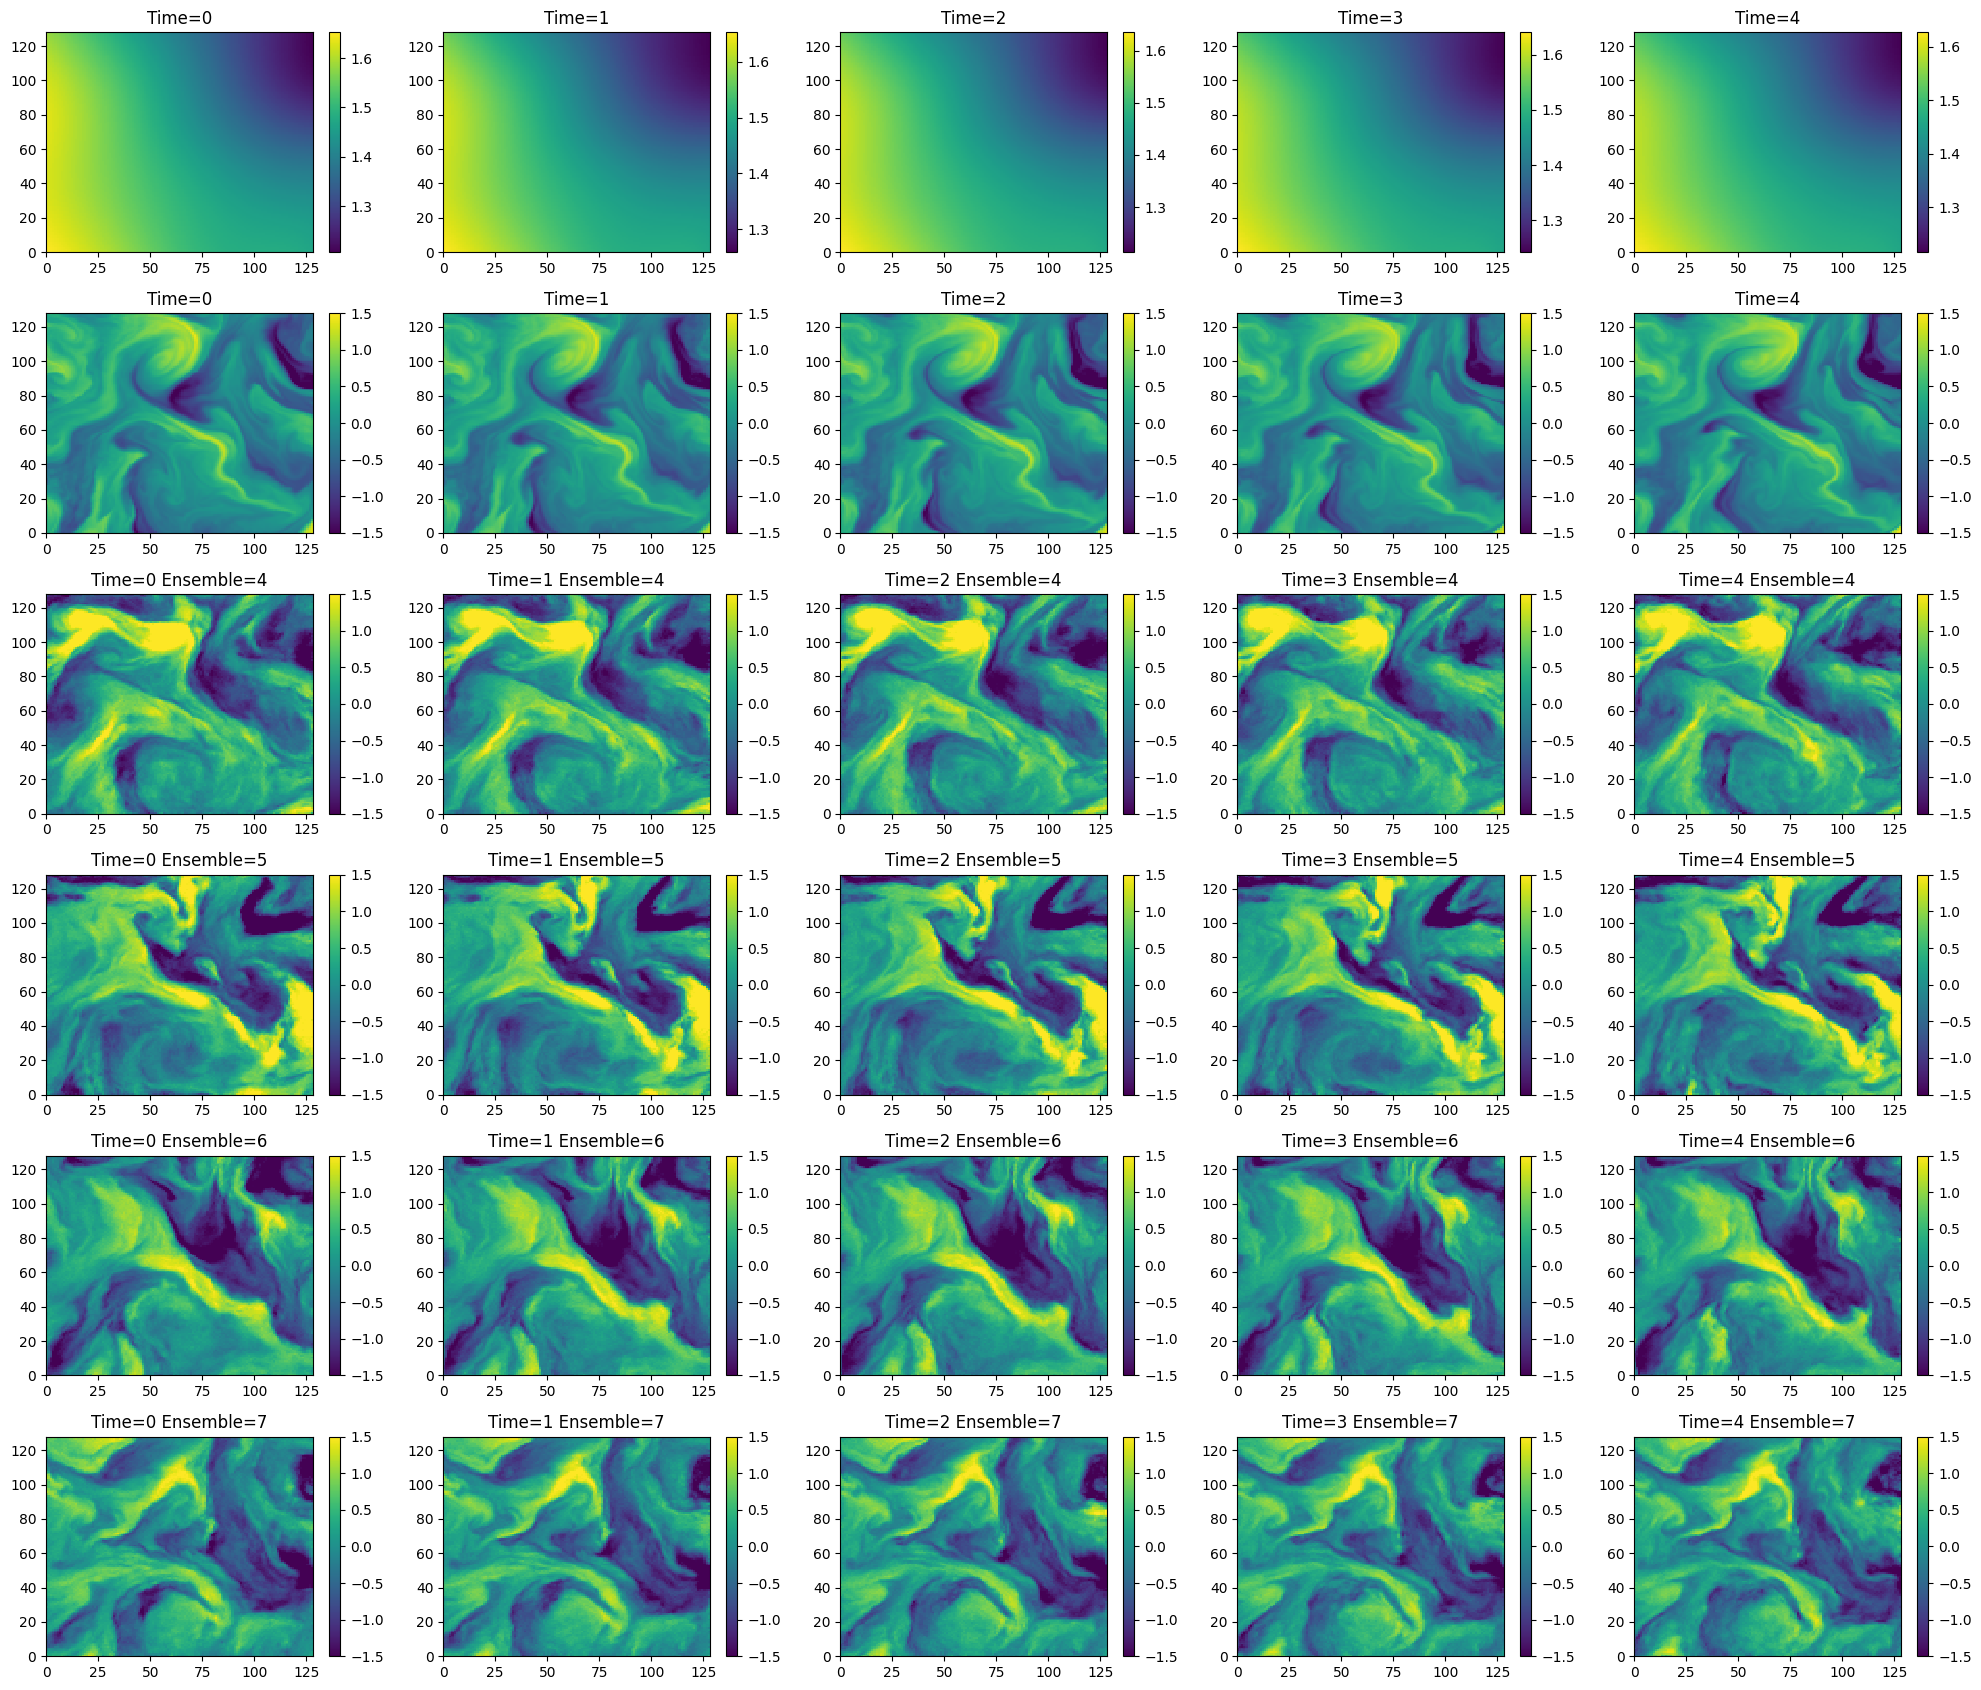

In [16]:
plt.figure(figsize=(20,17))

vmin = -1.5
vmax = 1.5
var_num = 1

for i in range(5):
    plt.subplot(6,5,1+i)
    plt.pcolormesh(image_lr[i + var_num*5,:,:])
    plt.colorbar()
    plt.title("Time="+str(i))

for i in range(5):
    plt.subplot(6,5,6+i)
    plt.pcolormesh(image_tar[i + var_num*5,:,:], vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title("Time="+str(i))

n=0
for j in range(4,8):
    for i in range(5):
        
        plt.subplot(6,5,11+n)
        n = n+1
        plt.pcolormesh(output_diffusion[j,i + var_num*5 ,:,:].cpu().numpy(), vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Time="+str(i)+' Ensemble='+str(j))

plt.tight_layout()

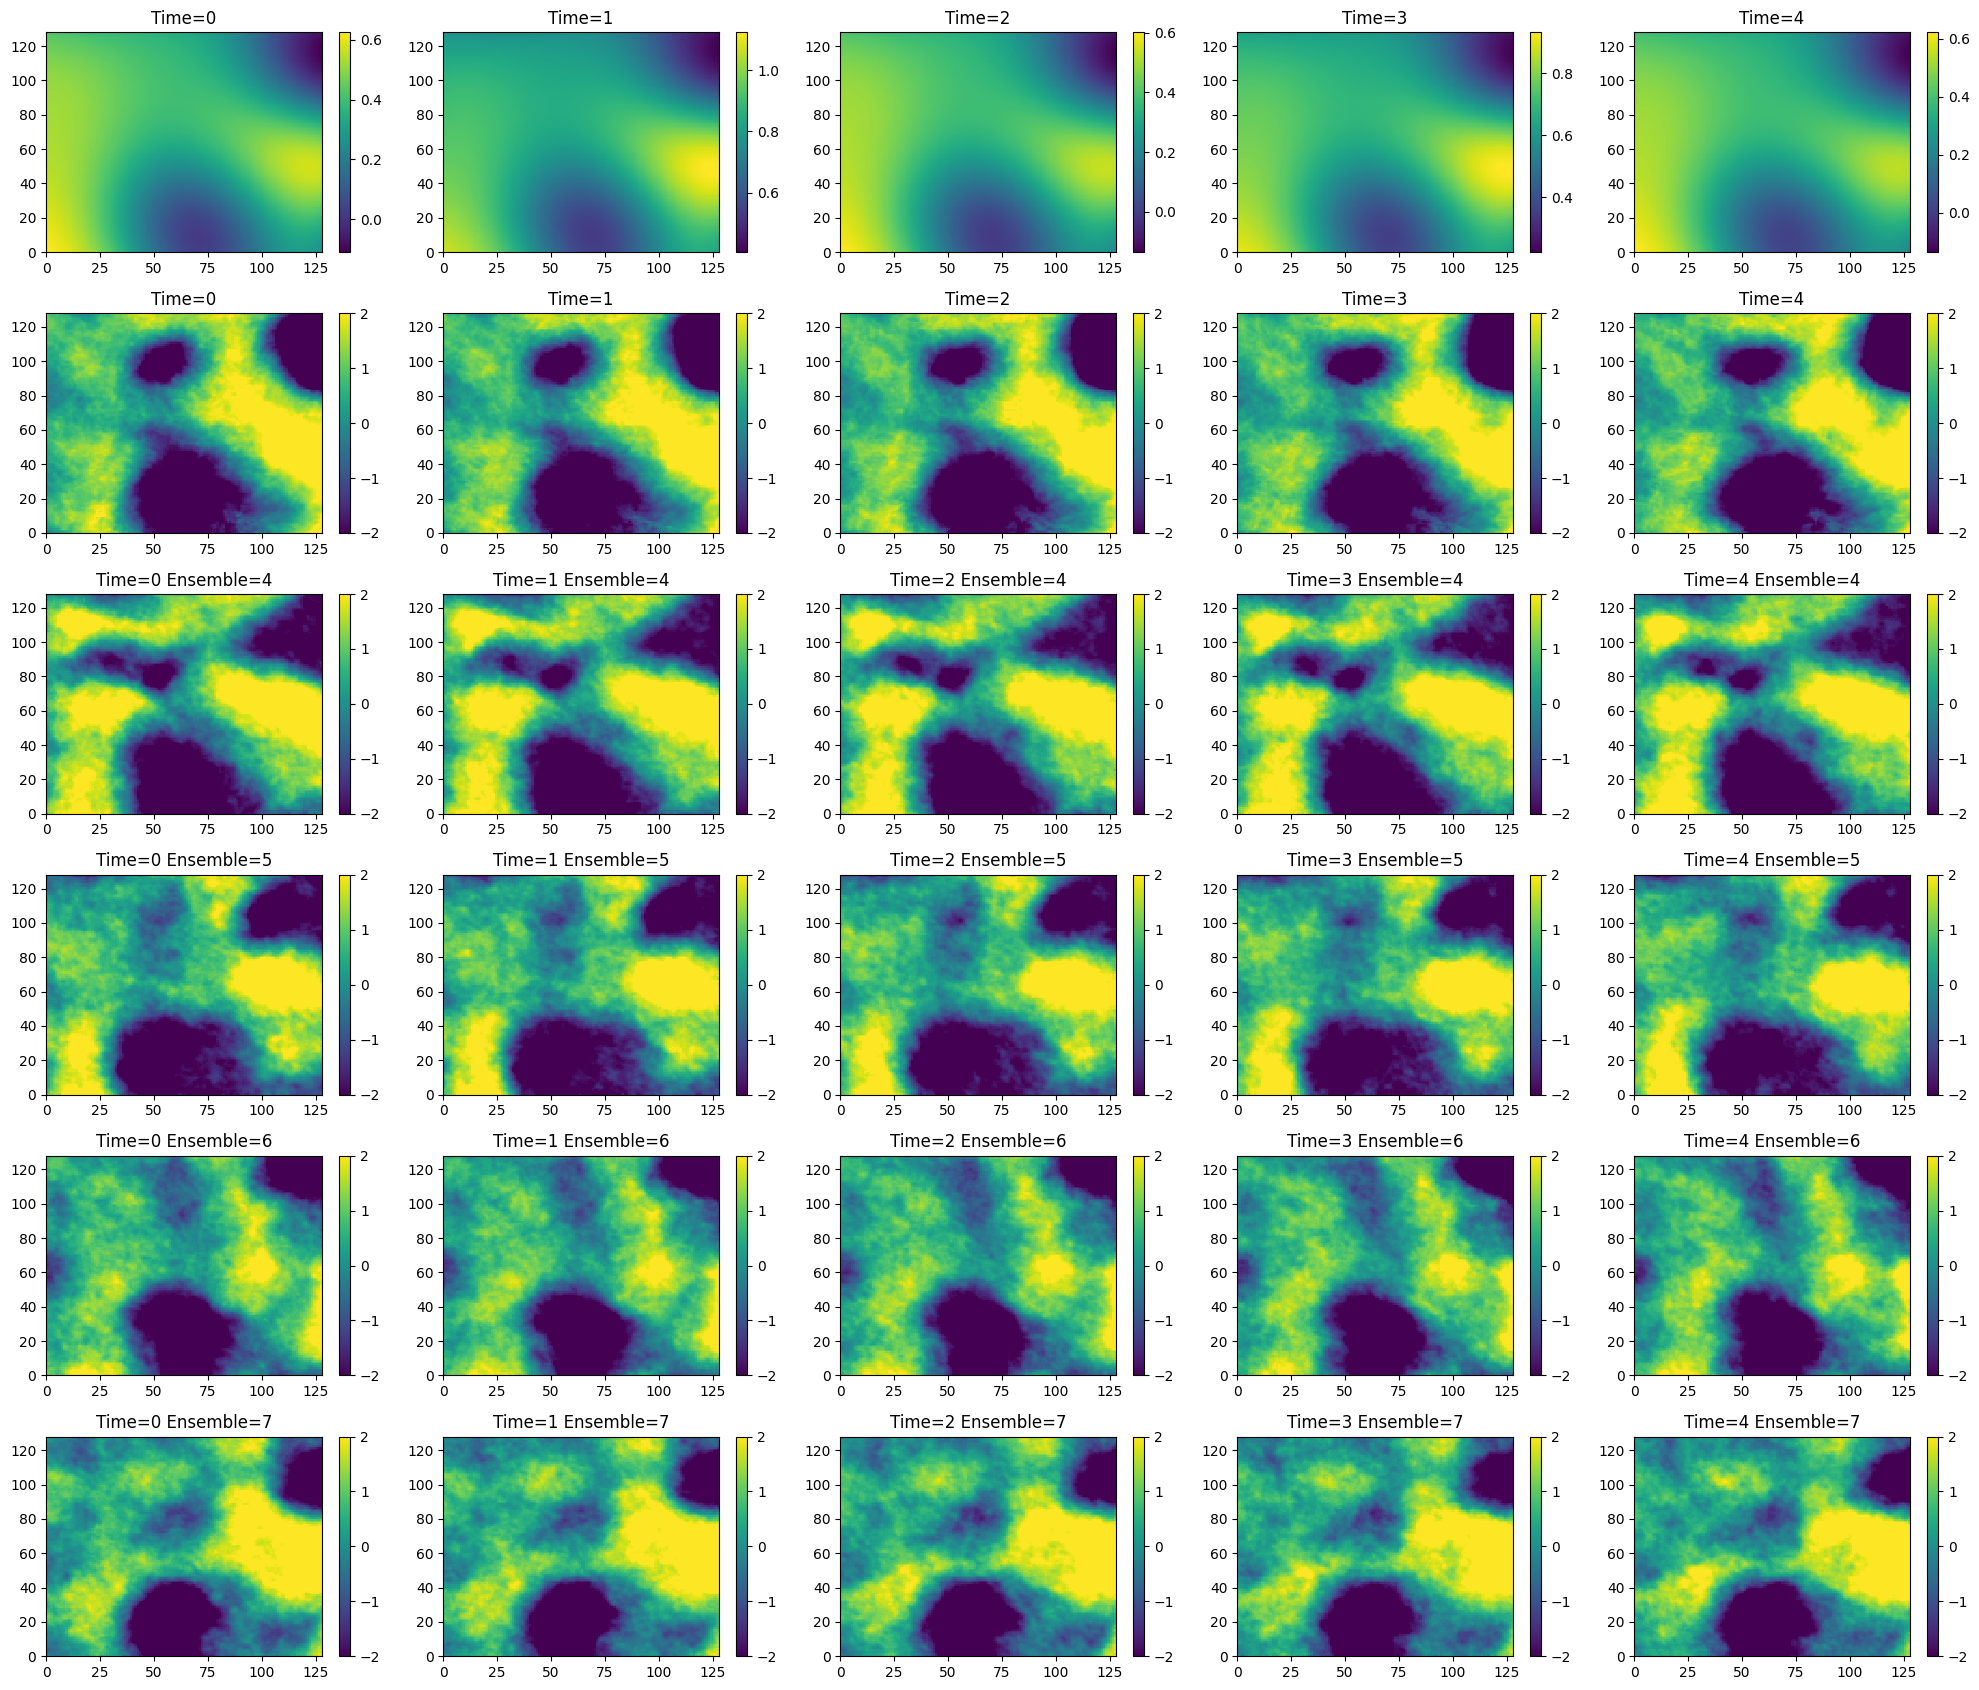

In [17]:
plt.figure(figsize=(20,17))

vmin = -2
vmax = 2
var_num = 0

for i in range(5):
    plt.subplot(6,5,1+i)
    plt.pcolormesh(image_lr[i + var_num*5,:,:])
    plt.colorbar()
    plt.title("Time="+str(i))

for i in range(5):
    plt.subplot(6,5,6+i)
    plt.pcolormesh(image_tar[i + var_num*5,:,:], vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title("Time="+str(i))

n=0
for j in range(4,8):
    for i in range(5):
        
        plt.subplot(6,5,11+n)
        n = n+1
        plt.pcolormesh(output_diffusion[j,i + var_num*5 ,:,:].cpu().numpy(), vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Time="+str(i)+' Ensemble='+str(j))

plt.tight_layout()

In [124]:
import xrft

In [125]:
import xarray as xr

In [126]:
ds_all = xr.Dataset()

In [127]:
ds_all['LR'] = xr.DataArray(image_lr, dims = ('channel', 'y', 'x'))
ds_all['HR_tar'] = xr.DataArray(image_tar, dims = ('channel', 'y', 'x'))
ds_all['HR_pred'] = xr.DataArray(output_diffusion.cpu().numpy(), dims = ('ensemble', 'channel', 'y', 'x'))

In [128]:
ds_all

<xarray.Dataset> Size: 8MB
Dimensions:  (channel: 10, y: 128, x: 128, ensemble: 10)
Dimensions without coordinates: channel, y, x, ensemble
Data variables:
    LR       (channel, y, x) float32 655kB 0.6248 0.6225 0.6195 ... 1.218 1.216
    HR_tar   (channel, y, x) float32 655kB -0.2391 -0.1856 ... -0.4947 -0.5379
    HR_pred  (ensemble, channel, y, x) float32 7MB 0.4318 0.629 ... 0.3354

In [129]:
ps_LR = xrft.isotropic_power_spectrum(ds_all['LR'], dim=['y', 'x'], truncate=True)
ps_HR_tar = xrft.isotropic_power_spectrum(ds_all['HR_tar'], dim=['y', 'x'], truncate=True)
ps_HR_pred = xrft.isotropic_power_spectrum(ds_all['HR_pred'], dim=['y', 'x'], truncate=True)

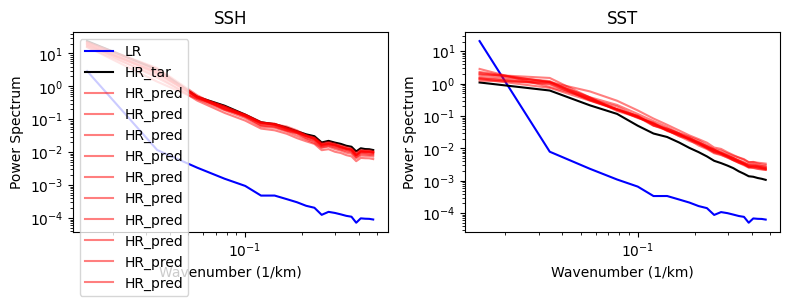

In [130]:
plt.figure(figsize=(8,3))

plt.subplot(121)
ps_LR.isel(channel=slice(0,5)).mean('channel').plot(label='LR', color='b')
ps_HR_tar.isel(channel=slice(0,5)).mean('channel').plot(label='HR_tar', color='k')

for i in range(num_ensembles):
    ps_HR_pred.isel(ensemble=i, channel=slice(0,5)).mean('channel').plot(label='HR_pred', color='r', alpha=0.5)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Wavenumber (1/km)')
plt.ylabel('Power Spectrum')
plt.legend()
plt.title('SSH')


plt.subplot(122)
ps_LR.isel(channel=slice(5,None)).mean('channel').plot(label='LR', color='b')
ps_HR_tar.isel(channel=slice(5, None)).mean('channel').plot(label='HR_tar', color='k')

for i in range(num_ensembles):
    ps_HR_pred.isel(ensemble=i, channel=slice(5,None)).mean('channel').plot(label='HR_pred', color='r', alpha=0.5)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Wavenumber (1/km)')
plt.ylabel('Power Spectrum')

plt.title('SST')

plt.tight_layout()


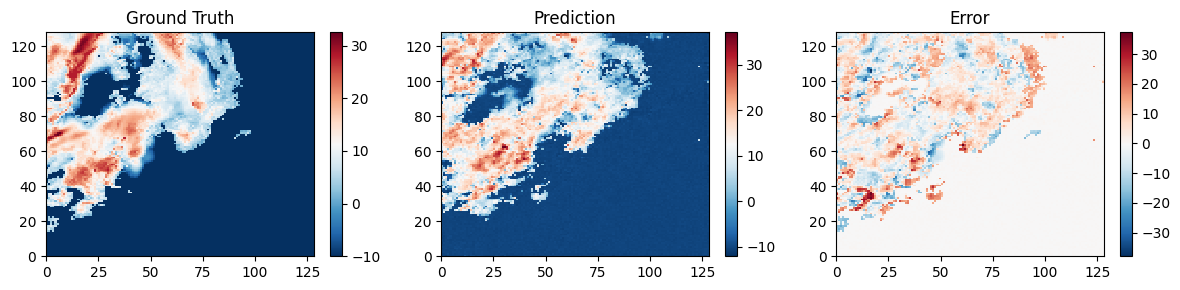

In [65]:
# ==============================================================================
# STEP 7: Denormalize and Visualize
# ==============================================================================
import matplotlib.pyplot as plt

# Denormalize (convert back to physical units)
output_phys = dataset.denormalize_output(output_combined[0].cpu().numpy())
target_phys = dataset.denormalize_output(image_tar_t.cpu().numpy())

# Plot first channel (e.g., temperature)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].pcolormesh(target_phys[0], cmap='RdBu_r')
fig.colorbar(axes[0].collections[0], ax=axes[0])
axes[0].set_title('Ground Truth')

axes[1].pcolormesh(output_phys[0], cmap='RdBu_r')
fig.colorbar(axes[1].collections[0], ax=axes[1])
axes[1].set_title('Prediction')

axes[2].pcolormesh(output_phys[0] - target_phys[0], cmap='RdBu_r')
fig.colorbar(axes[2].collections[0], ax=axes[2])
axes[2].set_title('Error')

plt.tight_layout()
plt.show()